In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
import warnings
import pydot as pyd
import seaborn as sns
import pandas as pd
from timeit import default_timer as timer
import matplotlib.pyplot as plt

warnings.simplefilter(action = 'ignore', category = FutureWarning)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";

# GPUid to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Insert initial parameters
img_height, img_width = 224, 224
batch_size = 64
n_classes = 3

# Data augmentation
train_datagen = ImageDataGenerator(#horizontal_flip = True, 
                                   #vertical_flip = True,
                                   #rotation_range = 45,
                                   brightness_range = [0.5, 2],
                                   samplewise_center = True,
                                   #fill_mode = 'constant',
                                   rescale = 1./255)
#                                    preprocessing_function = preprocess_input)
test_datagen = ImageDataGenerator(horizontal_flip = False, 
                                  vertical_flip = False,
                                  rotation_range = 0,
                                  samplewise_center = True,
                                  rescale = 1./255)
#                                   preprocessing_function = preprocess_input)

train = train_datagen.flow_from_directory('/local/data1/elech646/Tumor_grade_classification/dataset224_t2_frontal/train', 
                                          classes = ['G2','G3','G4'], color_mode = 'rgb', 
                                          class_mode = 'categorical', 
                                          target_size = (img_height, img_width), 
                                          batch_size = batch_size, seed = 123)
validation = test_datagen.flow_from_directory('/local/data1/elech646/Tumor_grade_classification/dataset224_t2_frontal/val', 
                                              classes = ['G2','G3','G4'], color_mode = 'rgb',
                                              class_mode = 'categorical', 
                                              target_size = (img_height, img_width), 
                                              batch_size = batch_size, seed = 123)
test = test_datagen.flow_from_directory('/local/data1/elech646/Tumor_grade_classification/dataset224_t2_frontal/test', 
                                        classes = ['G2','G3','G4'], color_mode = 'rgb',
                                        shuffle = False, class_mode = 'categorical', 
                                        target_size = (img_height, img_width), 
                                        batch_size = batch_size)

Found 5992 images belonging to 3 classes.
Found 1676 images belonging to 3 classes.
Found 593 images belonging to 3 classes.


In [3]:
# Use class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                                  classes = np.unique(train.classes), 
                                                  y = train.classes)

# Convert to dictionary
class_weights = dict(enumerate(class_weights))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 224, 224, 3) (64, 3)
-0.3553801


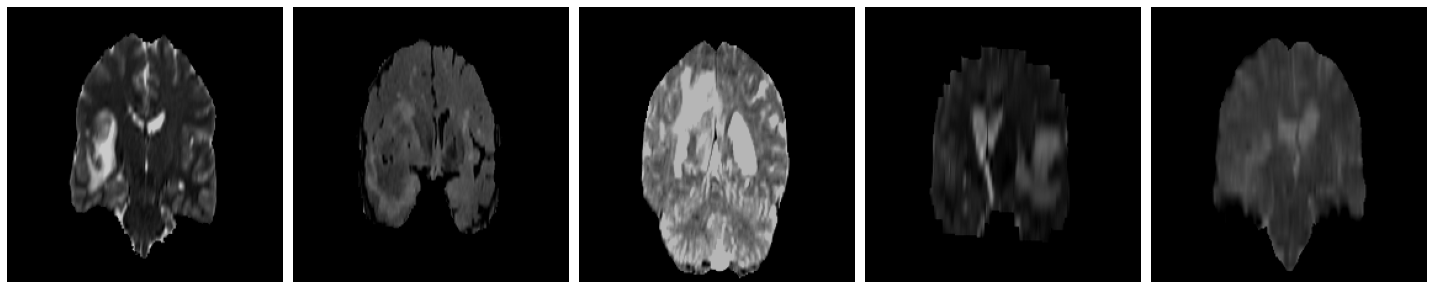

In [4]:
x_train, y_train = next(iter(train))
print(x_train.shape, y_train.shape)
print(x_train.min())

# Plot the images for fun
def plot_images(images):
    fig, axes = plt.subplots(1, 5, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in enumerate(axes):
        ax.imshow(images[img,:,:], cmap = 'gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_images(x_train[:1000])

In [21]:
# Load base model
vgg_19 = VGG19(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)

freeze_until_layer = 100

# Freeze all layers before the `freeze_until_layer` layer
for layer in vgg_19.layers[:freeze_until_layer]:
    layer.trainable = False

x = vgg_19.output
x = Flatten()(x)
x = Dense(50, activation = 'relu')(x) 
x = Dropout(0.4)(x)
x = Dense(20, activation = 'relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(n_classes, activation = 'softmax')(x)

model = Model(inputs = vgg_19.input, outputs = predictions)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

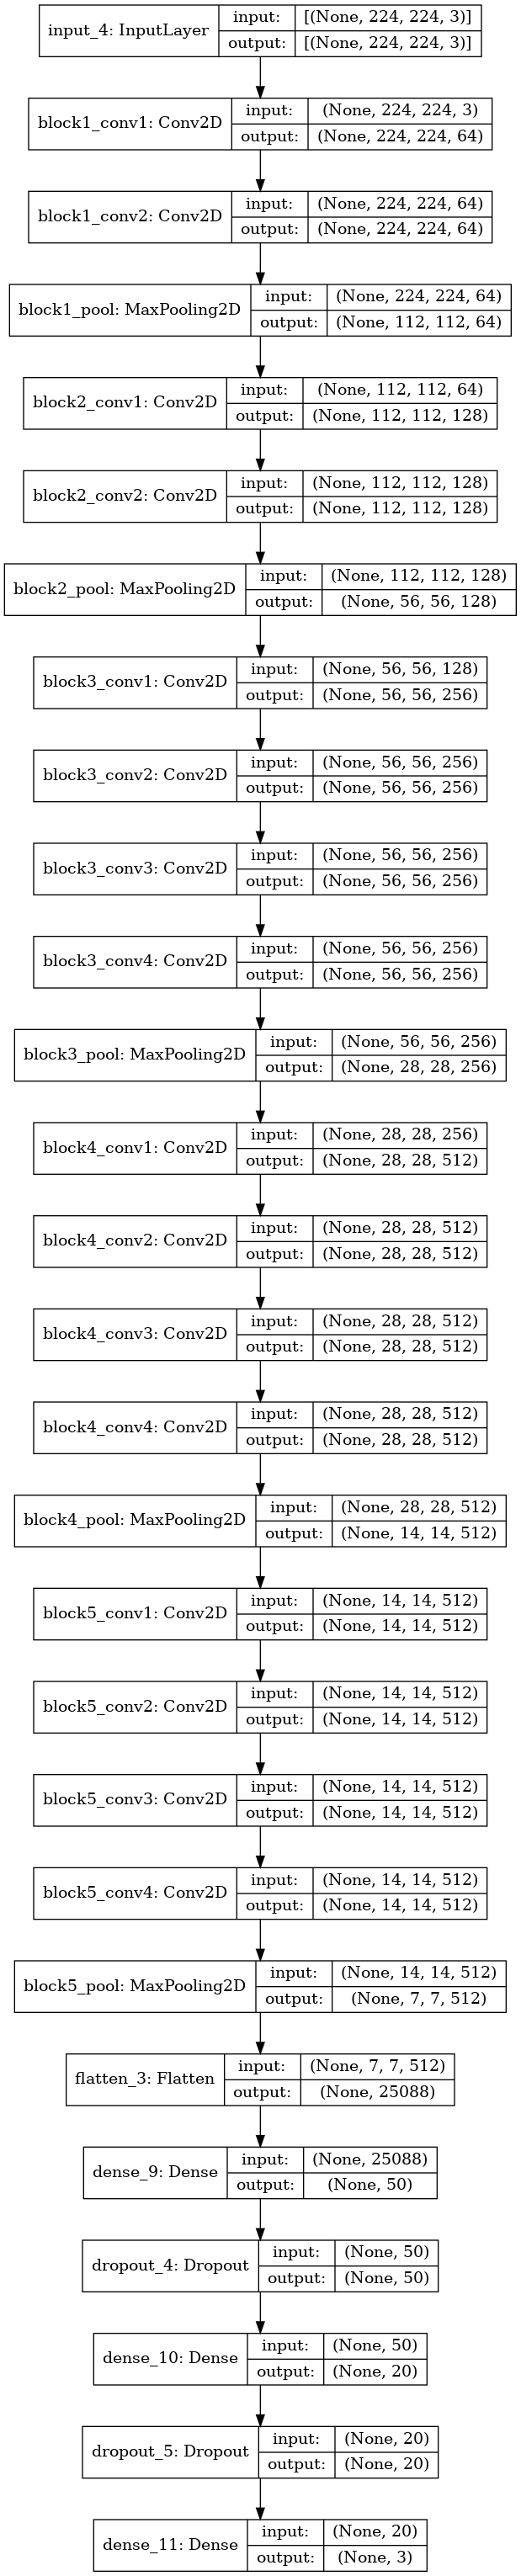

In [22]:
plot_model(model, to_file = 'vgg19_plot_t2_frontal.png', show_shapes = True, show_layer_names = True)

In [23]:
# Save best model
checkpoint_path = '/local/data1/elech646/code/train_logs/vgg19_transfer.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                monitor = 'val_accuracy',
                                                mode = 'max',
                                                verbose = 1,
                                                save_best_only = True)

# Save log for history
# append: True: append if file exists (useful for continuing training)
#         False: overwrite existing file
csv_logger = CSVLogger('/local/data1/elech646/code/train_logs/vgg19_transfer_history.log', 
                       separator = ',', append = True)

# Reduce learning rate if val_accuracy is not improving
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1,
                              patience = 5, min_lr = 0.000001)

es = EarlyStopping(monitor = 'val_accuracy', verbose = 1, patience = 15)

In [24]:
# Compile model
model.compile(Adam(lr = 1e-5),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])   

epochs = 30 
start = timer()

history = model.fit(train, steps_per_epoch = len(train.labels) // batch_size, verbose = 1,
                    epochs = epochs, validation_data = validation,
                    validation_steps = len(validation.labels) // batch_size,
                    class_weight = class_weights,
                    callbacks = [es, reduce_lr, checkpoint, csv_logger])

end = timer()
print("Training took: %.2fs\n" % (end - start))

Epoch 1/30
93/93 [==============================] - 15s 161ms/step - loss: 1.1989 - accuracy: 0.3359 - val_loss: 1.0383 - val_accuracy: 0.5998

Epoch 00001: val_accuracy improved from -inf to 0.59976, saving model to /local/data1/elech646/code/train_logs/vgg19_transfer.h5
Epoch 2/30
93/93 [==============================] - 15s 158ms/step - loss: 1.0377 - accuracy: 0.4508 - val_loss: 0.9400 - val_accuracy: 0.6412

Epoch 00002: val_accuracy improved from 0.59976 to 0.64123, saving model to /local/data1/elech646/code/train_logs/vgg19_transfer.h5
Epoch 3/30
93/93 [==============================] - 15s 158ms/step - loss: 0.9763 - accuracy: 0.5075 - val_loss: 0.8819 - val_accuracy: 0.6196

Epoch 00003: val_accuracy did not improve from 0.64123
Epoch 4/30
93/93 [==============================] - 15s 159ms/step - loss: 0.9542 - accuracy: 0.5094 - val_loss: 0.8663 - val_accuracy: 0.5901

Epoch 00004: val_accuracy did not improve from 0.64123
Epoch 5/30
93/93 [==============================] - 1

1st training:  

data augmentation: horizontal+vertical flip, rotation by 90 degrees

Setup: `x = vgg_19.output
        x = Flatten()(x)
        x = Dense(512, activation = 'relu')(x) # try 128, 64 the lower the better
        x = Dropout(0.5)(x)
        x = Dense(128, activation = 'relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(n_classes, activation = 'softmax')(x)`

epochs: 30

learning rate: 0.00001

training time: 649s $\approx 11$ min
                       
test accuracy: 0.4844 and smoother plot on `val_accuracy`

------------------------------------------------------------------------------------------------------------------

2nd training: 

data augmentation: `brightness_range = [0.5, 2]`

Setup: `x = vgg_19.output
        x = Flatten()(x)
        x = Dense(50, activation = 'relu')(x) 
        x = Dropout(0.4)(x)
        x = Dense(20, activation = 'relu')(x)
        x = Dropout(0.4)(x)
        predictions = Dense(n_classes, activation = 'softmax')(x)`
        
epochs: 30

learning rate: 1e-5 with `ReduceLROnPlateau` + `EarlyStopping`

training time: 254.94s $\approx 4$ min
                       
test accuracy: 0.6701

In [25]:
score = model.evaluate(test, steps = len(test.labels) // batch_size, verbose = 0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.8243
Test accuracy: 0.6701


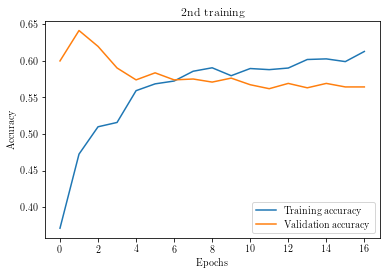

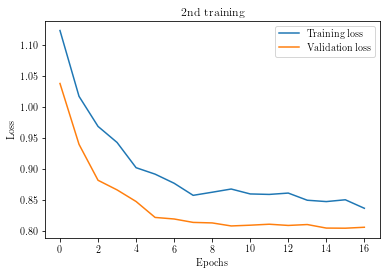

In [27]:
# Plot training + validation accuracy per epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
n_epochs = range(len(acc))

# for fancy LaTeX style plots
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex = True)

# Plot accuracy
plt.plot(n_epochs, acc, label = 'Training accuracy')
plt.plot(n_epochs, val_acc, label = 'Validation accuracy')
plt.title('2nd training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.savefig('VGG19_2nd_training_t2_frontal_acc.png', dpi = 300)
plt.show()

# Plot loss
plt.plot(n_epochs, loss, label = 'Training loss')
plt.plot(n_epochs, val_loss, label = 'Validation loss')
plt.title('2nd training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.savefig('VGG19_2nd_training_t2_frontal_loss.png', dpi = 300)
plt.show()

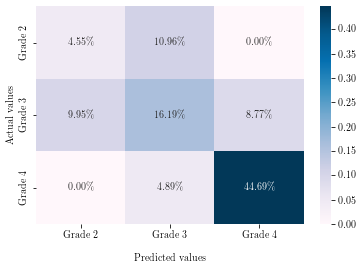

In [28]:
# Get rounded predictions
y_pred = np.argmax(model.predict(test), axis = 1) 

# Get true labels
y_true = test.classes

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

#ax = sns.heatmap(cm, annot = True, cmap = 'Blues')
ax = sns.heatmap(cm / np.sum(cm), annot = True, fmt = '.2%', cmap = 'PuBu')
for t in ax.texts: 
    t.set_text(t.get_text().replace('%', '\%'))
ax.set_xlabel('\nPredicted values')
ax.set_ylabel('Actual values ');
# list must be in alphabetical order
ax.xaxis.set_ticklabels(['Grade 2','Grade 3', 'Grade 4'])
ax.yaxis.set_ticklabels(['Grade 2','Grade 3', 'Grade 4'])
plt.savefig('VGG19_2nd_training_CM_t2_frontal.png', dpi = 300)
plt.show()

In [29]:
# Print classification report
print(classification_report(y_true, y_pred))

# Save the classification report
clsf_report = pd.DataFrame(classification_report(y_true = y_true, y_pred = y_pred, output_dict = True)).transpose()
clsf_report.to_csv('Classification Report-2nd Training on t2 frontal.csv', index = True)

              precision    recall  f1-score   support

           0       0.31      0.29      0.30        92
           1       0.51      0.46      0.48       207
           2       0.84      0.90      0.87       294

    accuracy                           0.65       593
   macro avg       0.55      0.55      0.55       593
weighted avg       0.64      0.65      0.65       593

